In [1]:
import treeswift
import subprocess
import dendropy
import treedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec

from io import StringIO
from Bio import Phylo
from matplotlib.transforms import Bbox

%load_ext autoreload
%autoreload 2

from helpers.utils import distdict_to_df, leaf_pairs, get_geno_dict, plot_state_counts, OKABE

In [2]:
lp_map_probs = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_clone3.petracer.neighbor_joining.binary_posterior_probs.csv"
lp_map_probs_df = pd.read_csv(lp_map_probs,index_col=0)
lp_map_probs_df = lp_map_probs_df.loc[[x for x in lp_map_probs_df.index if not x.startswith('internal_')]]

In [3]:
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_clone3.petracer.neighbor_joining.binary_tree.newick"
pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_clone3.petracer.neighbor_joining.nwk'

pet_tree = treeswift.read_tree_newick(pet_tree_fname) #[:-4] + ".scaled.newick")
lp_tree = treeswift.read_tree_newick(lp_tree_fname)
pet_tree.scale_edges(6/pet_tree.height())
lp_tree.scale_edges(6/lp_tree.height())

newick_str = lp_tree.newick()

In [4]:
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))
pet_distmat = distdict_to_df(pet_tree.distance_matrix(leaf_labels=True))

In [5]:
pet_input_geno = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/colonies_clone3_petracer_genotypes.csv"
pet_input_geno_df = pd.read_csv(pet_input_geno)
pet_geno_df = pet_input_geno_df[['cellBC', 'target_idx', 'pet_geno', 'pet_prob']].rename(columns={'cellBC': 'cell_name', 
                                                                                      'target_idx': 'target_site',
                                                                                      'pet_geno': 'pet_geno'})
pet_genocall_df = pet_geno_df.pivot(index='cell_name', columns='target_site', values='pet_geno').sort_index(axis=1).fillna(-1).astype(int)

In [7]:
import re

def parse_prob_string(s, cast_key=int):
    if pd.isna(s) or s == "": 
        return {}
    out = {}
    for kv in str(s).split("/"):
        if not kv: 
            continue
        k, v = kv.split(":", 1)
        try:    k = cast_key(k.strip())
        except: k = k.strip()
        out[k] = float(v)
    return out

In [8]:
nested = (lp_map_probs_df
          .applymap(parse_prob_string)
          .to_dict(orient="index"))

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_5110/1996806988.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(parse_prob_string)


In [9]:

    
rows = {}
for cell, char_map in nested.items():
    rows[cell] = {char: max(prob_map, key=prob_map.get) for char, prob_map in char_map.items()}

lp_genocall_df = pd.DataFrame.from_dict(rows, orient='index')

In [10]:
lp_genocall_df

,character_0,character_1,character_2,character_3,character_4,character_5,character_6,character_7,character_8,character_9,...,character_38,character_39,character_40,character_41,character_42,character_43,character_44,character_45,character_46,character_47
colony-22248,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,0,2,8,0,0,0
colony-22093,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,0,2,8,0,0,0
colony-22259,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,5,2,8,0,0,0
colony-21312,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,1,2,8,0,0,0
colony-22096,8,0,5,5,4,5,3,4,6,0,...,0,4,3,2,0,2,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
colony-21837,8,8,1,5,4,7,0,0,0,8,...,-1,4,7,8,1,5,8,0,5,0
colony-22034,8,1,5,5,7,7,5,8,6,0,...,5,7,5,8,1,5,8,0,5,0
colony-22131,8,0,0,5,0,7,8,8,6,4,...,5,0,5,8,1,5,8,0,5,0
colony-22139,8,0,0,5,0,0,3,8,7,8,...,6,3,3,8,1,5,8,0,5,0


In [11]:
def _conflict_from_dict(d):
    if not d: 
        return np.nan
    vals = sorted(d.values())
    top = vals[-1]
    second = vals[-2] if len(vals) >= 2 else 0.0
    return top - second


In [12]:
def top2(d, conflict_thresh=0.3):
    if not d or len(d) < 2:
        return False
    top2 = sorted(d.items(), key=lambda kv: kv[1], reverse=True)[:2]
    no_conflict = ((top2[0][1] - top2[1][1]) <= conflict_thresh) & ((top2[0][1] + top2[1][1]) >= 0.6)
    is_silenced = (top2[0][0] == -1) | (top2[1][0] == -1)
    return top2, no_conflict & (not is_silenced) # {top2[0][0], top2[1][0]} == {0, 8}

### Look at LAML-Pro genotye probabilities

In [13]:
# # Build a wide DataFrame: rows = cells, cols = characters, values = conflict
# conflict_df = pd.DataFrame({
#     cell: {char: _conflict_from_dict(state_probs) for char, state_probs in chars.items()}
#     for cell, chars in nested.items()
# }).T

In [14]:
nested['colony-22248']['character_0']

{-1: 0.0,
 0: 9e-06,
 1: 7e-06,
 2: 7.8e-05,
 3: 1e-06,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 1e-06,
 8: 0.999903}

I want to see that cells with similar uncertainty are grouped together in the tree. If so, you would expect to see that expected hamming distance between cells correlates better with phylogenetic distance.

### expected hamming distance

##### Helper functions

In [15]:
def get_probvec(d, *, states, normalize=True): #, exclude_states={}, normalize=True):
    vals = [(s, float(d.get(s, 0.0))) for s in states]
    v = np.array([float(d.get(s, 0.0)) for s in states], dtype=float)
    mass = v.sum()
    if normalize and mass > 0:
        v = v / mass
    return v, mass, max(vals, key=lambda kv:kv[1])[0]

In [16]:
def hellinger(p, q):
    return (1 / np.sqrt(2)) * np.linalg.norm(np.sqrt(p) - np.sqrt(q))

In [17]:
def dist_pairs(
    nested, cell_a, cell_b, *,
    characters=None,
    missing_codes=(-1,),
    normalize=True,
    keep_argmax=True,
    reduction="mean",   # "mean" or "sum"
    weighted=True       # if True and reduction="mean", weight by prob both non-missing
):
    if (cell_a not in nested) or (cell_b not in nested):
        return np.nan

    chars = set(nested[cell_a].keys()).intersection(nested[cell_b].keys())
    if characters is not None:
        chars = chars.intersection(characters)
    if not chars:
        return np.nan

    vals, weights = [], []
    mism, wsum = 0.0, 0.0
    for ch in chars:
        da = nested[cell_a][ch]
        db = nested[cell_b][ch]
        #print(da)
        # print(db)

        states = da.keys()
        p, mass_p, max_state_p = get_probvec(da, states=states,
                                             normalize=normalize)
        q, mass_q, max_state_q = get_probvec(db, states=states, 
                                             normalize=normalize)
        # d = 1.0 - float(np.dot(p, q))
        d = hellinger(p, q)
        w = float(mass_p * mass_q)
        vals.append(d)
        weights.append(w)

        w_argmax = 0.0 if (max_state_p in missing_codes or max_state_q in missing_codes) else 1.0
        # print(w_argmax, max_state_p, max_state_q, max_state_p != max_state_q)
        if w_argmax > 0:
            mism += float(max_state_p != max_state_q)
            wsum += w_argmax

    # mean
    vals = np.asarray(vals, float)
    weights = np.asarray(weights, float)
    if weighted:
        wsum = weights.sum()
        return float(np.sum(vals * weights) / wsum) if wsum > 0 else np.nan, mism/wsum
    else:
        return float(vals.mean()), mism/wsum


In [18]:
def pairwise_hamming(df: pd.DataFrame, missing=-1, normalize: bool = True) -> pd.DataFrame:
    X = df.to_numpy()
    obs = (X != missing)  # observed mask

    # Overlap: number of sites observed in both cells (n x n)
    overlap = obs.astype(np.int64) @ obs.T.astype(np.int64)

    # Matches where both observed
    matches = ((X[:, None, :] == X[None, :, :]) & 
               (obs[:, None, :] & obs[None, :, :])).sum(axis=2)

    mismatches = overlap - matches  # count of disagreements on jointly observed sites

    if normalize:
        dist = np.zeros_like(mismatches, dtype=float)
        # Avoid divide-by-zero; leave 0 where overlap==0 (or set to np.nan if preferred)
        np.divide(mismatches, overlap, out=dist, where=overlap > 0)
    else:
        dist = mismatches.astype(float)

    return pd.DataFrame(dist, index=df.index, columns=df.index)

##### Run the code

In [19]:
tmp = {'cell1': {'character_1': {1: 0.5, 2: 0.5, 3: 0.0}},
       'cell2': {'character_1': {1: 0.5, 2: 0.5, 3: 0.0}},
       'cell3': {'character_1': {1: 1.0, 2: 0.0, 3: 0.0}},
       'cell4': {'character_1': {1: 0.9, 2: 0.1, 3: 0.0}},
       'cell5': {'character_1': {1: 0.0, 2: 1.0, 3: 0.0}}}

In [20]:
dist_pairs(tmp, 'cell1', 'cell2')

(0.0, np.float64(0.0))

In [21]:
dist_pairs(tmp, 'cell1', 'cell3')

(0.5411961001461969, np.float64(0.0))

In [22]:
dist_pairs(tmp, 'cell4', 'cell3')

(0.2265319005117959, np.float64(0.0))

In [23]:
dist_pairs(tmp, 'cell3', 'cell5')

(1.0, np.float64(1.0))

This indicates the angular distance between the genotype probability vectors. Importantly, this value should be small when we have similar genotype probability vectors, and the identity is 0. Note that this treatment of ties is a bit careless, but I expect ties to be rare in the real data where we have continuous values. 

In [29]:
cells = [c for c in lp_distmat.index if c in nested]  # align with nested
geno_dists = pd.DataFrame(np.nan, index=cells, columns=cells, dtype=float)
argmax_geno_dists = pd.DataFrame(np.nan, index=cells, columns=cells, dtype=float)

for i, a in enumerate(cells):
    geno_dists.iat[i, i] = 0.0
    argmax_geno_dists.iat[i, i] = 0.0
    for j in range(i+1, len(cells)):
        b = cells[j]
        d, argmax_hd = dist_pairs(
            nested, a, b,
            normalize=True
        )
        geno_dists.iat[i, j] = d
        geno_dists.iat[j, i] = d
        argmax_geno_dists.iat[i, j] = argmax_hd
        argmax_geno_dists.iat[j, i] = argmax_hd

# --- assemble pair table (upper triangle, finite only) ---
pairs = []
for i, a in enumerate(cells):
    for j in range(i+1, len(cells)):
        b = cells[j]
        phy = lp_distmat.loc[a, b]
        gd  = geno_dists.loc[a, b]
        hd  = argmax_geno_dists.loc[a, b]
        # if np.isfinite(phy) and np.isfinite(eh):
        pairs.append((a, b, phy, gd, hd))

pairs_df = pd.DataFrame(pairs, columns=["cell_a", "cell_b", "phylo", "hellinger_dist", "argmax geno HD"])

In [30]:
pairs_df

,cell_a,cell_b,phylo,hellinger_dist,argmax geno HD
0,colony-22319,colony-21859,11.842853,0.573997,0.541667
1,colony-22319,colony-21281,10.307594,0.497282,0.479167
2,colony-22319,colony-21754,11.537958,0.717159,0.687500
3,colony-22319,colony-21729,11.842853,0.620463,0.562500
4,colony-22319,colony-21493,11.842847,0.497614,0.479167
...,...,...,...,...,...
241160,colony-21396,colony-22101,11.842870,0.422160,0.291667
241161,colony-21396,colony-21831,11.842870,0.715511,0.604166
241162,colony-21408,colony-22101,11.096115,0.577325,0.458333
241163,colony-21408,colony-21831,11.537969,0.738505,0.687500


In [31]:
# add the phylogenetic distance according to convexML
pairs_df = pd.DataFrame(pairs, columns=["cell_a", "cell_b", "laml-pro-phylo", "hellinger_dist", "laml-pro-argmax-geno-HD"])

In [32]:
pet_distmat.max().max(), lp_distmat.max().max()

(np.float64(11.999999999933088), np.float64(11.84288175101581))

In [33]:
pet_distmat.min().min(), lp_distmat.min().min()

(np.float64(0.0), np.float64(0.0))

In [34]:
# add 'petracer-phylo'
idx = pairs_df.set_index(['cell_a', 'cell_b']).index
pairs_df['petracer-phylo'] = pet_distmat.stack().reindex(idx).to_numpy()
pairs_df

,cell_a,cell_b,laml-pro-phylo,hellinger_dist,laml-pro-argmax-geno-HD,petracer-phylo
0,colony-22319,colony-21859,11.842853,0.573997,0.541667,9.184946
1,colony-22319,colony-21281,10.307594,0.497282,0.479167,8.017005
2,colony-22319,colony-21754,11.537958,0.717159,0.687500,12.000000
3,colony-22319,colony-21729,11.842853,0.620463,0.562500,9.184946
4,colony-22319,colony-21493,11.842847,0.497614,0.479167,9.184946
...,...,...,...,...,...,...
241160,colony-21396,colony-22101,11.842870,0.422160,0.291667,9.184946
241161,colony-21396,colony-21831,11.842870,0.715511,0.604166,12.000000
241162,colony-21408,colony-22101,11.096115,0.577325,0.458333,8.944821
241163,colony-21408,colony-21831,11.537969,0.738505,0.687500,12.000000


In [35]:
# want to add pet_genocall_phy

lp_whd = pairwise_hamming(lp_genocall_df, missing=-1, normalize=True)

In [36]:
pet_whd = pairwise_hamming(pet_genocall_df, missing=-1, normalize=True)

In [37]:
pairs_df['lp-genoargmax-whd'] = lp_whd.stack().reindex(idx).to_numpy()
pairs_df['petracer-genoargmax-whd'] = pet_whd.stack().reindex(idx).to_numpy()

In [38]:
np.corrcoef(pairs_df["laml-pro-phylo"], pairs_df["hellinger_dist"])[0, 1]

np.float64(0.6362588841463996)

In [39]:
# np.corrcoef(pairs_df["laml-pro-phylo"], pairs_df["laml-pro-argmax-geno-HD"])[0, 1]

In [40]:
np.corrcoef(pairs_df["laml-pro-phylo"], pairs_df["lp-genoargmax-whd"])[0, 1]

np.float64(0.6303362526131232)

In [41]:
np.corrcoef(pairs_df["laml-pro-phylo"], pairs_df["petracer-genoargmax-whd"])[0, 1]

np.float64(0.6210004687645829)

In [42]:
np.corrcoef(pairs_df["petracer-phylo"], pairs_df["laml-pro-argmax-geno-HD"])[0, 1]

np.float64(0.8505740492233056)

In [43]:
np.corrcoef(pairs_df["petracer-phylo"], pairs_df["lp-genoargmax-whd"])[0, 1]

np.float64(0.8578043129765611)

In [44]:
np.corrcoef(pairs_df["petracer-phylo"], pairs_df["petracer-genoargmax-whd"])[0, 1]

np.float64(0.8099249990773837)

This is treating -1 as just another state.

Observations:
- LAML-Pro phylogenetic distance is better correlated with the LAML-Pro genotype uncertainty (hellinger) than with the LAML-Pro argmax genotypes. 
- LAML-Pro phylogenetic distance is better correlated with the LAML-Pro argmax genotype wHD than LAML-Pro argmax genotype HD
- PEtracer (ConvexML) phylogenetic distance is *much* better correlated with the LAML-Pro argmax genotype wHD (r=0.86) (and HD r=0.85) than the LAML-Pro phylogenetic distance is (wHD: r=0.63, HD=0.62). 
- PEtracer (ConvexML) phylogenetic distance is *much* better correlated with the LAML-Pro argmax genotype wHD (r=0.86) (and HD r=0.85) than the petracer genotypes (r=0.81).

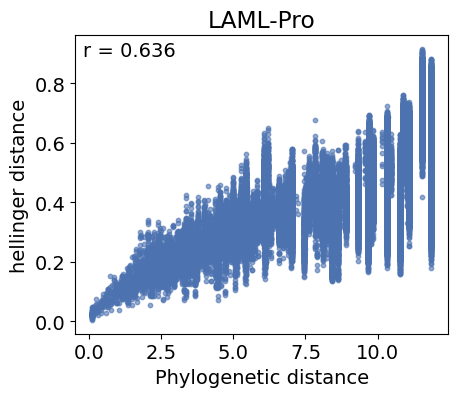

In [45]:

# --- scatter plot ---
plt.figure(figsize=(4.8, 4.2))
plt.scatter(pairs_df["laml-pro-phylo"], pairs_df["hellinger_dist"], s=10, alpha=0.6)
plt.xlabel("Phylogenetic distance")
plt.ylabel("hellinger distance")
# plt.ylabel("Genotype argmax wHD")
plt.title("LAML-Pro")

# optional: annotate Pearson r
if len(pairs_df) > 1:
    r = np.corrcoef(pairs_df["laml-pro-phylo"], pairs_df["hellinger_dist"])[0, 1]
    plt.text(0.02, 0.98, f"r = {r:.3f}", transform=plt.gca().transAxes, va="top")

plt.tight_layout()
plt.show()


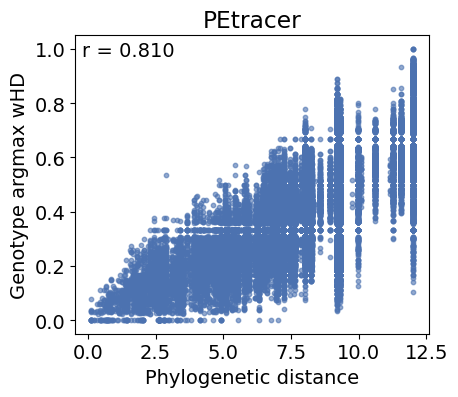

In [46]:

# --- scatter plot ---
plt.figure(figsize=(4.8, 4.2))
plt.scatter(pairs_df["petracer-phylo"], pairs_df["petracer-genoargmax-whd"], s=10, alpha=0.6)
plt.xlabel("Phylogenetic distance")
plt.ylabel("Genotype argmax wHD")
plt.title("PEtracer")

# optional: annotate Pearson r
if len(pairs_df) > 1:
    r = np.corrcoef(pairs_df["petracer-phylo"], pairs_df["petracer-genoargmax-whd"])[0, 1]
    plt.text(0.02, 0.98, f"r = {r:.3f}", transform=plt.gca().transAxes, va="top")

plt.tight_layout()
plt.show()


### visualize

In [ ]:
cells  = list(nested.keys())
sites  = sorted({site for d in nested.values() for site in d.keys()})

# matrix with nullable integers so we can keep NAs
mat = pd.DataFrame(index=cells, columns=sites, dtype="Int64")

for cell, ts_dict in nested.items():
    for site, state_probs in ts_dict.items():
        res = top2(state_probs)          # ([(g1,p1),(g2,p2)], keep_flag) or False
        if not res: 
            continue
        (pairs, keep) = res
        if not keep:
            continue
        g1, g2 = pairs[0][0], pairs[1][0]
        if g1 == 0 or g2 == 0:
            other = g2 if g1 == 0 else g1
            if other != 0:
                mat.at[cell, site] = other

# mat now has the nonzero genotype for qualifying (cell, site) pairs; others are <NA>

In [ ]:
mat = mat.astype(float)

In [ ]:
tree = Phylo.read(StringIO(newick_str), "newick")
tree.ladderize(True)  # cosmetic
leaves = [t.name for t in tree.get_terminals()]

df = mat.copy()
df = df.apply(pd.to_numeric, errors="coerce").fillna(-1).astype(int)

row_order = [x for x in leaves if x in df.index]
if not row_order:
    raise ValueError("No overlapping leaf names between Newick and DataFrame index.")
df = df.loc[row_order]

df

In [ ]:
def mrca_height_from_root(tree, leaf_a: str, leaf_b: str):
    mrca = tree.mrca({leaf_a, leaf_b})
    
    return tree.distance_between(tree.root, mrca)

In [ ]:
pairs = [] 
rows = df.index.to_list()
for col in df.columns:
    vals = df[col].to_numpy()
    # scan for *adjacent* equal, non -1 values
    for i in range(1, len(vals)):
        v, v_prev = vals[i], vals[i-1]
        if (v is not None) and (v_prev is not None) \
           and not (pd.isna(v) or pd.isna(v_prev)) \
           and v != -1 and v_prev != -1 and v == v_prev:
            pairs.append((rows[i-1], rows[i], col, int(v)))


In [ ]:
heights = []
pairs_with_heights = []
for a, b, col, state in pairs:
    try:
        h = mrca_height_from_root(lp_tree, a, b)
        heights.append(h)
        pairs_with_heights.append((a, b, col, state, h))
    except StopIteration:
        # leaf not found in tree; skip gracefully
        continue

In [ ]:
pair_df = pd.DataFrame(pairs_with_heights, columns=["cell_a","cell_b","character","state","height_from_root"])

# Plot the distribution
plt.figure(figsize=(5,3.2), dpi=150)
plt.hist(heights, bins=50)
plt.xlabel("MRCA height from root")
plt.ylabel("Count")
plt.title("Consecutive identical (≠ -1) pairs: MRCA heights")
plt.tight_layout()
plt.show()

# If you also want a quick numeric summary:
summary = pair_df["height_from_root"].describe()
print(summary)

In [ ]:
lp_chars = mat
metric = "hamming",
method = "average",
title  = "Colony: LAML-Pro genotypes",
vmin = -1
vmax = 8
dpi = 150
tree_panel_ratio = 0.2
show_cell_names = False

tree = Phylo.read(StringIO(newick_str), "newick")
tree.ladderize(True)  # cosmetic
leaves = [t.name for t in tree.get_terminals()]

df = lp_chars.copy()
df = df.apply(pd.to_numeric, errors="coerce").fillna(-1).astype(int)

row_order = [x for x in leaves if x in df.index]
if not row_order:
    raise ValueError("No overlapping leaf names between Newick and DataFrame index.")
df = df.loc[row_order]

# ---------- 2) Cluster columns (no dendrogram displayed) ----------
# dists = pdist(df.values.T, metric=metric)
# Zc = linkage(dists, method=method, metric=metric)
# col_order = leaves_list(Zc)
# df_ord = df.iloc[:, col_order]
df_ord = df

# ---------- 3) Discrete palette (Okabe–Ito style) ----------
categories = np.arange(vmin, vmax + 1)
# build a palette long enough; keep index 0 grey for -1 if present
# We'll map bins with BoundaryNorm so -1 gets its own bin.
n_needed = len(categories)
if n_needed > len(OKABE):
    # extend with repeated cycle if needed (rare)
    mult = int(np.ceil(n_needed / len(OKABE)))
    pal = (OKABE * mult)[:n_needed]
else:
    pal = OKABE[:n_needed]
cmap = ListedColormap(pal)
bounds = np.arange(vmin - 0.5, vmax + 1.5, 1.0)
norm = BoundaryNorm(bounds, cmap.N)

# ---------- 4) Layout: left tree, right heatmap ----------
fig = plt.figure(figsize=(8, 4.5), dpi=dpi) #, constrained_layout=True)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[tree_panel_ratio, 1 - tree_panel_ratio], wspace=0.0)
ax_tree = fig.add_subplot(gs[0, 0])
ax_heat = fig.add_subplot(gs[0, 1])
plt.subplots_adjust(wspace=0.0)
ax_tree.margins(x=0.0, y=0.0)

# ----- Heatmap (no dendrogram) -----
sns.heatmap(
    df_ord,
    ax=ax_heat,
    cmap=cmap, norm=norm, vmin=vmin, vmax=vmax,
    xticklabels=False,
    yticklabels=show_cell_names,
    cbar=False,
    rasterized=False,
)
ax_heat.set_title(title, fontsize=16)
ax_heat.set_aspect('auto')

ax_heat.set_xlabel("Target sites", fontsize=13)
ax_heat.set_ylabel("Cell names" if show_cell_names else "", fontsize=13)
ax_heat.tick_params(axis="both", labelsize=11)
if show_cell_names:
    # ensure one label per row at centered positions
    n_rows = df_ord.shape[0]
    ax_heat.set_yticks(np.arange(n_rows) + 0.5)
    ax_heat.set_yticklabels(df_ord.index.tolist(), rotation=0, fontsize=11)
    ax_heat.yaxis.set_ticks_position('left')

# Black border around heatmap to match your style
for side in ("left", "right", "top", "bottom"):
    ax_heat.spines[side].set_visible(True)
    ax_heat.spines[side].set_linewidth(1.5)
    ax_heat.spines[side].set_edgecolor("black")

# Shared horizontal colorbar (like your function)
box_h = ax_heat.get_position()
cax   = fig.add_axes([box_h.x1 + 0.004, box_h.y0, 0.018, box_h.height])  # tweak 0.004/0.018 if needed
cbar  = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
# cbar = fig.colorbar(
#     plt.cm.ScalarMappable(norm=norm, cmap=cmap),
#     ax=[ax_heat], orientation="vertical", fraction=0.08 #, pad=0.08
# )
cbar.set_ticks(categories)
ticklabels = ["?/-1" if x == -1 else str(x) for x in categories]
cbar.set_ticklabels(ticklabels)

# ----- Tree (no labels) -----
Phylo.draw(tree, axes=ax_tree, do_show=False, show_confidence=False, label_func=lambda _: None)
for coll in ax_tree.collections:   # LineCollection used by Bio.Phylo
    coll.set_linewidth(0.4)        # e.g., 0.3–0.6 works well
for ln in ax_tree.lines:           # just in case any Line2D were drawn
    ln.set_linewidth(0.4)
    
ax_tree.invert_yaxis()          # top row = first leaf
ax_tree.set_xmargin(0)
x0, x1 = ax_tree.dataLim.x0, ax_tree.dataLim.x1
ax_tree.set_xlim(x0 +0.01, x1 + 0.01)

ax_tree.set_xticks([]); ax_tree.set_yticks([])
ax_tree.set_xlabel(""); ax_tree.set_ylabel(""); ax_tree.set_title("")
ax_tree.margins(x=0.0)
# ax_tree.set_ylim(ax_heat.get_ylim()[0]-0.1, ax_heat.get_ylim()[1]-0.1)
box_t = ax_tree.get_position(); box_h = ax_heat.get_position()
ax_heat.set_position([box_t.x1, box_h.y0, box_h.width + (box_h.x0 - box_t.x1), box_h.height])
ax_heat.set_position([box_t.x1 - 0.001, box_h.y0, (box_h.x1 - box_t.x1) + 0.001, box_h.height])

for sp in ax_tree.spines.values():
    sp.set_visible(False)
    
# if outfile:
#     fig.savefig(outfile, bbox_inches="tight", dpi=dpi)


### Starting code to compare phylogenetic distance against expected hamming distance

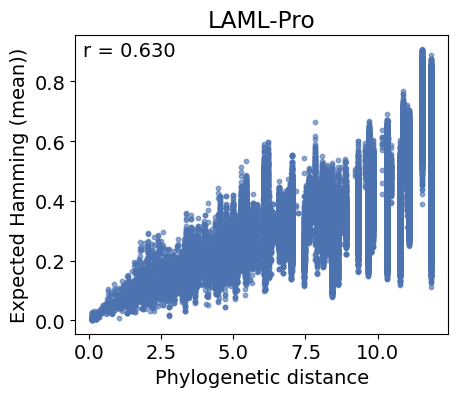

In [26]:

# --- scatter plot ---
plt.figure(figsize=(4.8, 4.2))
plt.scatter(pairs_df["phylo"], pairs_df["exp_hamming_mean"], s=10, alpha=0.6)
plt.xlabel("Phylogenetic distance")
plt.ylabel("Expected Hamming (mean))")
plt.title("LAML-Pro")

# optional: annotate Pearson r
if len(pairs_df) > 1:
    r = np.corrcoef(pairs_df["phylo"], pairs_df["exp_hamming_mean"])[0, 1]
    plt.text(0.02, 0.98, f"r = {r:.3f}", transform=plt.gca().transAxes, va="top")

plt.tight_layout()
plt.show()


In [27]:

def hamming_argmax_weighted_between_cells_allchars(
    nested, cell_a, cell_b, *,
    characters=None,
    states=(-1, 0, 1, 2, 3, 4, 5, 6, 7, 8),   # include -1 explicitly
    missing_codes=(-1,),                       # any of these => zero weight
    return_fraction=True
):
    """
    Weighted Hamming between argmax state vectors across characters.
    Weight = 0 if either argmax is in `missing_codes`, else 1.
    If return_fraction, returns sum(weight * [a!=b]) / sum(weight).

    Returns float in [0,1] or np.nan if no weighted comparisons.
    """
    if (cell_a not in nested) or (cell_b not in nested):
        return np.nan

    chars = set(nested[cell_a]).intersection(nested[cell_b])
    if characters is not None:
        chars = chars.intersection(characters)
    if not chars:
        return np.nan

    mism, wsum = 0.0, 0.0
    for ch in chars:
        da = nested[cell_a].get(ch, {})
        db = nested[cell_b].get(ch, {})
        if da is None or db is None:
            continue
        a = _argmax_state(da, states)
        b = _argmax_state(db, states)
        if a is None or b is None:
            continue

        w = 0.0 if (a in missing_codes or b in missing_codes) else 1.0
        if w > 0:
            mism += float(a != b)
            wsum += w

    if wsum == 0:
        return np.nan
    return (mism / wsum) if return_fraction else mism

# ---- Build weighted-argmax Hamming matrix aligned to lp_distmat ----
def build_weighted_argmax_hamming_matrix(nested, lp_distmat,
                                         states=(-1,0,1,2,3,4,5,6,7,8),
                                         missing_codes=(-1,),
                                         return_fraction=True):
    cells = [c for c in lp_distmat.index if c in nested]
    ham = pd.DataFrame(np.nan, index=cells, columns=cells, dtype=float)
    for i, a in enumerate(cells):
        ham.iat[i, i] = 0.0
        for j in range(i+1, len(cells)):
            b = cells[j]
            d = hamming_argmax_weighted_between_cells_allchars(
                nested, a, b, states=states, missing_codes=missing_codes,
                return_fraction=return_fraction
            )
            ham.iat[i, j] = d
            ham.iat[j, i] = d
    return ham

# ---- Scatter vs phylogenetic distance (like before) ----
def scatter_phylo_vs_weighted_hamming(lp_distmat, ham_mat, title="Phylo vs. weighted Hamming (argmax)"):
    cells = ham_mat.index.intersection(lp_distmat.index)
    pairs = []
    for i, a in enumerate(cells):
        for j in range(i+1, len(cells)):
            b = cells[j]
            phy = lp_distmat.loc[a, b]
            ham = ham_mat.loc[a, b]
            if np.isfinite(phy) and np.isfinite(ham):
                pairs.append((phy, ham))
    if not pairs:
        print("No comparable pairs found.")
        return
    x, y = np.array(pairs).T
    plt.figure(figsize=(4.6, 4.2))
    plt.scatter(x, y, s=9, alpha=0.6)
    plt.xlabel("Phylogenetic distance")
    ylabel = "Weighted Hamming (argmax)" if np.nanmax(y) <= 1.0 else "Weighted Hamming (argmax; count)"
    plt.ylabel(ylabel)
    plt.title(title)
    if len(x) > 1:
        r = np.corrcoef(x, y)[0, 1]
        plt.text(0.02, 0.98, f"r = {r:.3f}", transform=plt.gca().transAxes, va="top")
    plt.tight_layout()
    plt.show()


In [28]:
ham_mat = build_weighted_argmax_hamming_matrix(nested, lp_distmat)

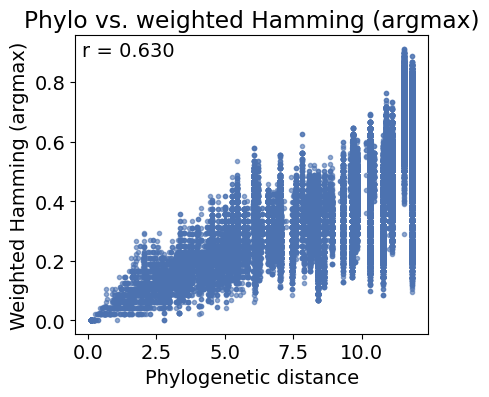

In [29]:
scatter_phylo_vs_weighted_hamming(lp_distmat, ham_mat)
